# soft attention 구현 및 roar 측정 
1. cam    
2. resnet   
3. resnet + bam   
4. resnet + cbam  

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

print(parentdir,currentdir)

/home/jake/Gits/AI college/XAI/2.problem /home/jake/Gits/AI college/XAI/2.problem/notebooks_backup


In [12]:
from imports import *

/home/jake/Gits/AI college/XAI /home/jake/Gits/AI college/XAI/2.problem
current-> /home/jake/Gits/AI college/XAI/2.problem/models
/home/jake/Gits/AI college/XAI/2.problem


# CAM

In [161]:
def show_images_gradcam(trainloader):
    images = []
    for i , (img, targets) in enumerate(trainloader):
        #print('오리지널:',img.shape)
        #img = img.squeeze()
        torch_img,normed_torch_img=normalize_image(img.cuda())
        #print(normed_torch_img)


        for gradcam, gradcam_pp in cam_dict.values():
            mask, _ = gradcam(normed_torch_img)
            #print(mask.shape,'df')
            heatmap, result = visualize_cam(mask, torch_img)
            #print('heatmap->{} result->{}',heatmap.shape,result.shape)

            images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))        
            img = img.squeeze()
            img = (img).permute(1, 2, 0)


        if i==10: break
    images = make_grid(torch.cat(images, 0), nrow=3)
    img_name = 'temp2.jpg'
    output_dir = 'outputs'
    os.makedirs(output_dir, exist_ok=True)
    output_name = img_name
    output_path = os.path.join(output_dir, output_name)

    save_image(images, output_path)
    PIL.Image.open(output_path)

In [2]:
from imports import *

/home/jake/Gits/AI college/XAI /home/jake/Gits/AI college/XAI/2.problem
current-> /home/jake/Gits/AI college/XAI/2.problem/models
/home/jake/Gits/AI college/XAI/2.problem


In [2]:
device = 'cuda'

train_loader_mnist = utils.load_data_mnist(batch_size=1,test=False)
test_loader_mnist = utils.load_data_mnist(batch_size=128,test=True)

LOAD DATA, 60000
LOAD DATA, 79


In [3]:
net_mnist = load__MnistCNN().cuda()
mnist_cam = CAM(net_mnist,train_loader_mnist,test_loader_mnist,device,'MNIST')

CAM


In [4]:
ratio = np.arange(0,1,0.1)
ratio

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Ratio-[0.0%] removed


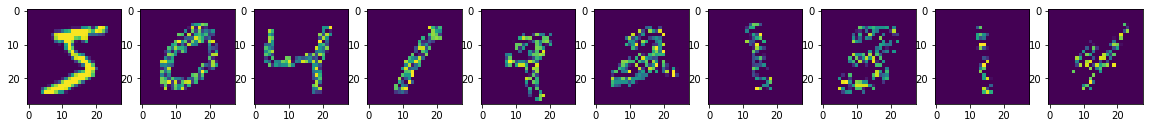

Ratio-[0.1%] removed


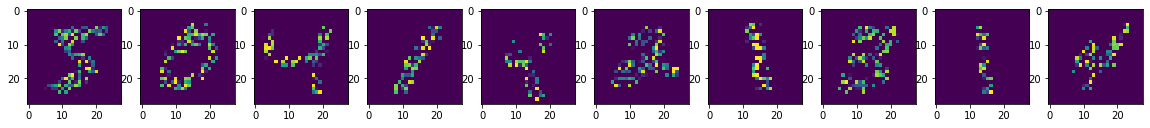

Ratio-[0.2%] removed


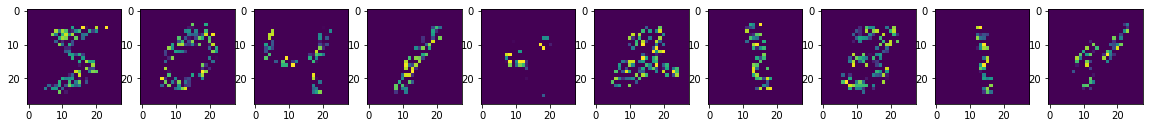

Ratio-[0.30000000000000004%] removed


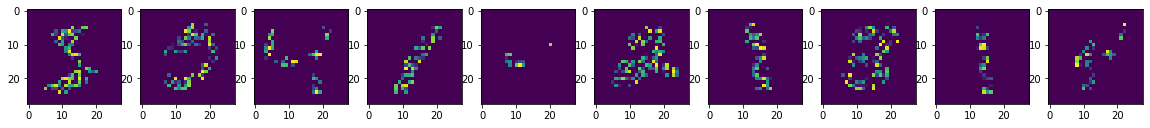

Ratio-[0.4%] removed


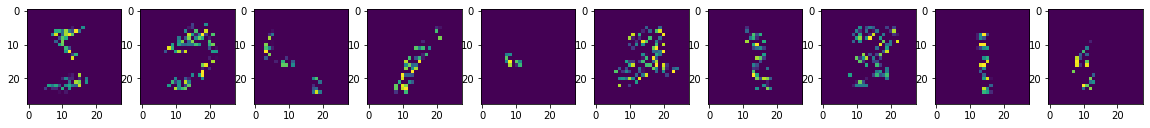

Ratio-[0.5%] removed


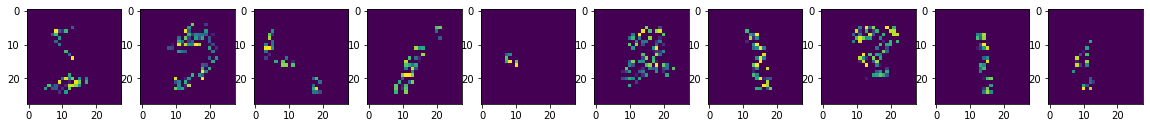

Ratio-[0.6000000000000001%] removed


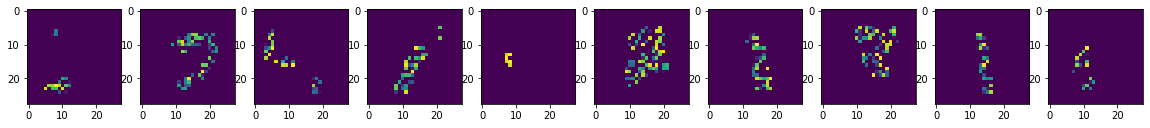

Ratio-[0.7000000000000001%] removed


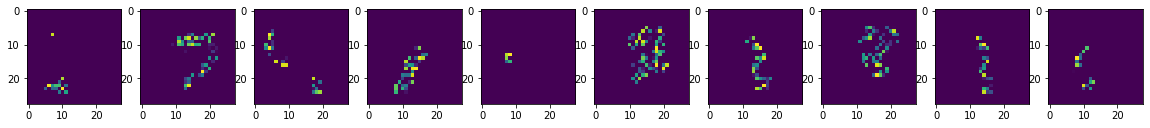

Ratio-[0.8%] removed


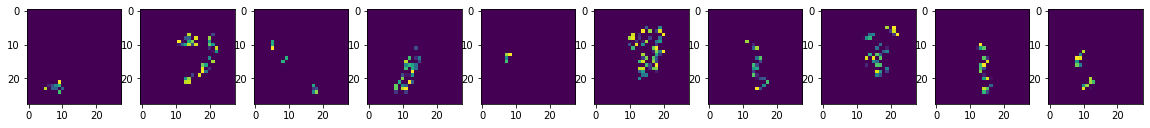

Ratio-[0.9%] removed


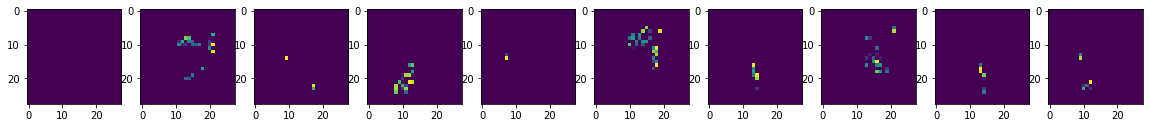

In [5]:
mnist_cam.show_images(limit=9,ratio=ratio)

# roar graph

In [66]:
acc_bs=[]
steps_bs=[]

In [67]:
save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
save_name=save_dir+ 'ROAR_adjust_3_CNN_mnist.pth.hdf5'

for i in ratio:
    save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
    save_name=save_dir+ 'ROAR_adjust_{}_CNN_mnist.pth.hdf5'.format(i)
    with h5py.File(save_name,'r') as hf:
        acc_b = np.array(hf['acc'])
        steps_b = np.array(hf['step'])
        acc_bs.append(acc_b)
        steps_bs.append(steps_b)

In [68]:
print(acc_bs)
print(steps_bs)

[array(75.95714286), array(80.72809524), array(80.83714286), array(88.13095238), array(73.33047619), array(81.56428571), array(82.36904762), array(76.22190476), array(80.98333333), array(72.43142857)]
[array(0.), array(0.1), array(0.2), array(0.3), array(0.4), array(0.5), array(0.6), array(0.7), array(0.8), array(0.9)]


In [69]:
np.array(acc_bs)

array([75.95714286, 80.72809524, 80.83714286, 88.13095238, 73.33047619,
       81.56428571, 82.36904762, 76.22190476, 80.98333333, 72.43142857])

In [70]:
acc_bs = np.array(acc_bs)
steps_bs = np.array(steps_bs)

In [73]:
acc_bs

array([0.75957143, 0.80728095, 0.80837143, 0.88130952, 0.73330476,
       0.81564286, 0.82369048, 0.76221905, 0.80983333, 0.72431429])

In [74]:
steps_bs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [71]:
f = lambda x: x/100
acc_bs=f(acc_bs)

f = lambda x: x/10
steps_bs = f(steps_bs)

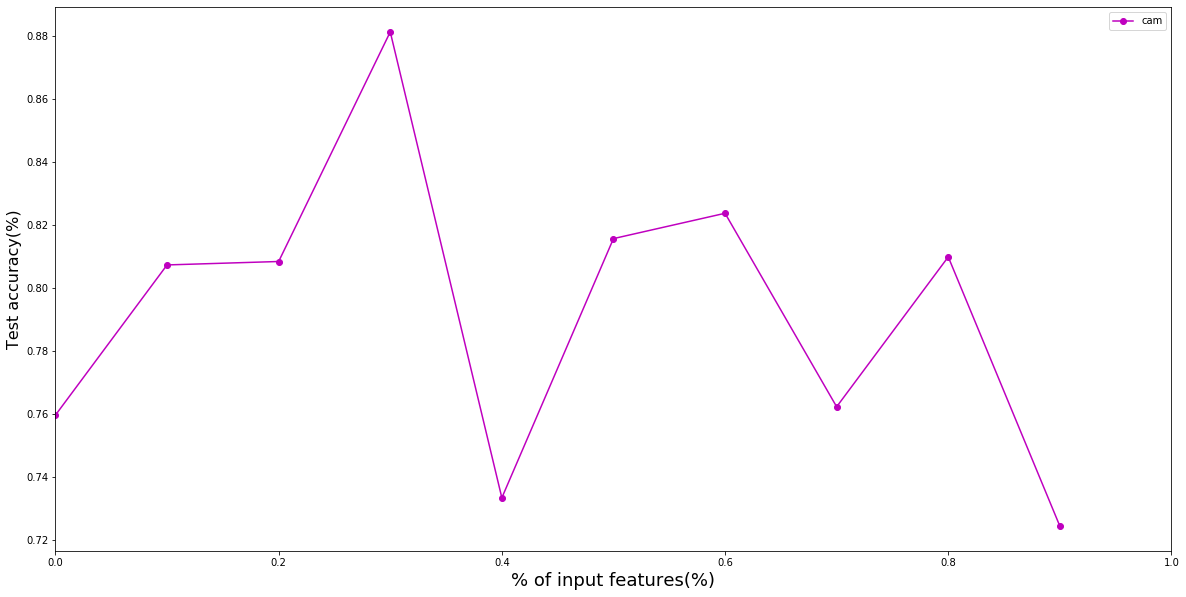

In [75]:
plt.plot(ratio,acc_bs,'-ok',marker='o',label="cam",color='m')
plt.xlabel('% of input features(%)',fontsize=18)
plt.ylabel('Test accuracy(%)',fontsize=16)
plt.legend(numpoints=1)
plt.xlim(0, 1);

# RESNET

In [74]:
import utilsxai
from attribution.attention.grad_cam import adjust_image

In [116]:
def adjust_image2(ratio, trainloader, saliency_maps, eval_method):

    data = trainloader.dataset.data
    img_size = data.shape[1:]  # mnist : (28,28), cifar10 : (32,32,3)
    print('img_size={}'.format(img_size))
    nb_pixel = np.prod(img_size)
    threshold = int(nb_pixel * (1 - ratio))
    # rank indice
    re_sal_maps = saliency_maps.reshape(saliency_maps.shape[0], -1)
    indice = re_sal_maps.argsort().argsort()
    # get mask
    if eval_method == 'ROAR':
        mask = indice < threshold
    elif eval_method == 'KAR':
        mask = indice >= threshold
    #mask = re_sal_maps
    mask = mask.reshape(data.shape)
    print('mask.shape->{} data_shape->{}'.format(mask.shape,data.shape))
    trainloader.dataset.data = (data * mask).reshape(data.shape)

    return trainloader

In [153]:
def show_images(trainloader,limit):
    for idx,(img,target) in enumerate(trainloader):
        img = img.squeeze()
        #pritn(img)
        img = torch.tensor(img)
        print(img.shape)
        img = (img).permute(1, 2, 0)
        plt.figure(figsize=(2,2))
        plt.imshow(img)
        plt.show()
        if idx==limit:break

In [118]:
hf = h5py.File(f'/home/jake/Gits/AI college/XAI/2.problem/masks/cifar10_temp_reshape.h5py','r')
sal_maps_hf= np.array(hf['saliencys'])

In [145]:
ratio = np.arange(0,1,0.1)
ratio

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

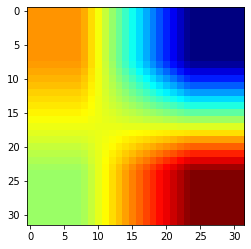

In [119]:
for idx,img in enumerate(sal_maps_hf):
    img = img.squeeze()
    img = torch.tensor(img)
    #img = (img).permute(1, 2, 0)
    plt.imshow(img)
    plt.show()
    if idx==0:break

In [151]:
trainloader = utilsxai.load_data_cifar10(batch_size=1,test=False)
testloader =  utilsxai.load_data_cifar10(batch_size=128, test=True)

Files already downloaded and verified
here
LOAD DATA, 50000
Files already downloaded and verified
here
LOAD DATA, 79


In [152]:
trainloader.dataset.data.shape

(50000, 32, 32, 3)

In [147]:
data = trainloader.dataset.data 

In [148]:
trainloader_b=adjust_image2(0.1, trainloader, sal_maps_hf, 'ROAR')

img_size=(32, 32, 3)
mask.shape->(50000, 32, 32, 3) data_shape->(50000, 32, 32, 3)


In [150]:
trainloader_b.dataset.data.shape

(50000, 32, 32, 3)

torch.Size([3, 32, 32])


/home/jake/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


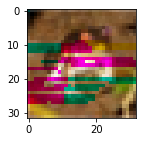

In [154]:
show_images(trainloader_b,0)

In [163]:
resnet = resnet50().cuda()
name = 'ROAR_adjust_0_Resnet'
resnet.load_state_dict(torch.load('/home/jake/Gits/AI college/XAI/2.problem/model_weights/{}.pth'.format(name)))
resnet.eval(),resnet.cuda()
from attribution.attention.grad_cam import *
cam_dict = get_camdic(resnet,'resnet','layer3')

resnet50-XAI
bloackexpsnsion 4 256
saliency_map size : torch.Size([2, 2])
saliency_map size : torch.Size([2, 2])


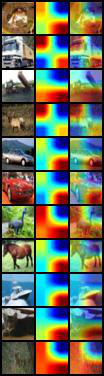

In [164]:
images = []
for i , (img, targets) in enumerate(trainloader):
    #print('오리지널:',img.shape)
    #img = img.squeeze()
    torch_img,normed_torch_img=normalize_image(img.cuda())
    #print(normed_torch_img)


    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        #print(mask.shape,'df')
        heatmap, result = visualize_cam(mask, torch_img)
        #print('heatmap->{} result->{}',heatmap.shape,result.shape)

        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))        
        img = img.squeeze()
        img = (img).permute(1, 2, 0)


    if i==10: break
images = make_grid(torch.cat(images, 0), nrow=3)
img_name = 'temp2.jpg'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

In [173]:
acc_bs=[]
steps_bs=[]

save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
save_name=save_dir+ 'ROAR_adjust_0_Resnet.pth'

for i in ratio:
    save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
    save_name=save_dir+ 'ROAR_adjust_{}_Resnet.pth.hdf5'.format(i)
    with h5py.File(save_name,'r') as hf:
        acc_b = np.array(hf['acc'])
        steps_b = np.array(hf['step'])
        acc_bs.append(acc_b)
        steps_bs.append(steps_b)

In [174]:
acc_bs

[array(52.26416667),
 array(46.015),
 array(44.24133333),
 array(42.4165),
 array(40.70616667),
 array(39.89783333),
 array(39.0665),
 array(35.31316667),
 array(32.94383333),
 array(28.77516667)]

In [175]:
steps_bs

[array(0.),
 array(0.1),
 array(0.2),
 array(0.3),
 array(0.4),
 array(0.5),
 array(0.6),
 array(0.7),
 array(0.8),
 array(0.9)]

In [177]:
acc_bs = np.array(acc_bs)
steps_bs = np.array(steps_bs)

f = lambda x: x/100
acc_bs=f(acc_bs)

f = lambda x: x/10
steps_bs = f(steps_bs)

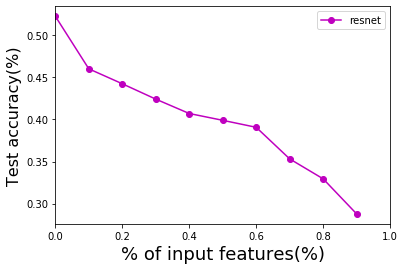

In [179]:
plt.plot(ratio,acc_bs,'-ok',marker='o',label="resnet",color='m')
plt.xlabel('% of input features(%)',fontsize=18)
plt.ylabel('Test accuracy(%)',fontsize=16)
plt.legend(numpoints=1)
plt.xlim(0, 1);

# BAM

In [155]:
resnet = resnet50().cuda()
name = 'ROAR_adjust_0_Resnet_BAM'
resnet.load_state_dict(torch.load('/home/jake/Gits/AI college/XAI/2.problem/model_weights/{}.pth'.format(name)))
resnet.eval(),resnet.cuda()

resnet50-XAI
bloackexpsnsion 4 256


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [156]:
trainloader = utilsxai.load_data_cifar10(batch_size=1,test=False)
testloader =  utilsxai.load_data_cifar10(batch_size=128, test=True)

Files already downloaded and verified
here
LOAD DATA, 50000
Files already downloaded and verified
here
LOAD DATA, 79


In [158]:
from attribution.attention.grad_cam import *
cam_dict = get_camdic(resnet,'resnet','layer3')

saliency_map size : torch.Size([2, 2])
saliency_map size : torch.Size([2, 2])


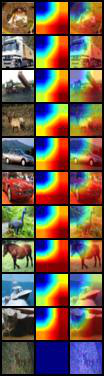

In [162]:
images = []
for i , (img, targets) in enumerate(trainloader):
    #print('오리지널:',img.shape)
    #img = img.squeeze()
    torch_img,normed_torch_img=normalize_image(img.cuda())
    #print(normed_torch_img)


    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        #print(mask.shape,'df')
        heatmap, result = visualize_cam(mask, torch_img)
        #print('heatmap->{} result->{}',heatmap.shape,result.shape)

        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))        
        img = img.squeeze()
        img = (img).permute(1, 2, 0)


    if i==10: break
images = make_grid(torch.cat(images, 0), nrow=3)
img_name = 'temp2.jpg'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)

In [13]:
import numpy as np
import h5py
ratio = np.arange(0,1,0.1)
ratio

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

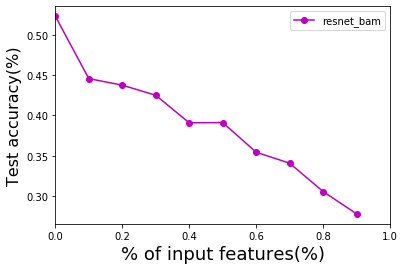

In [15]:
acc_bs=[]
steps_bs=[]

save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
save_name=save_dir+ 'ROAR_adjust_0_Resnet.pth'

for i in ratio:
    save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
    save_name=save_dir+ 'ROAR_adjust_{}_Resnet_BAM.pth.hdf5'.format(i)
    with h5py.File(save_name,'r') as hf:
        acc_b = np.array(hf['acc'])
        steps_b = np.array(hf['step'])
        acc_bs.append(acc_b)
        steps_bs.append(steps_b)
        
acc_bs = np.array(acc_bs)
steps_bs = np.array(steps_bs)

f = lambda x: x/100
acc_bs=f(acc_bs)

f = lambda x: x/10
steps_bs = f(steps_bs)


plt.plot(ratio,acc_bs,'-ok',marker='o',label="resnet_bam",color='m')
plt.xlabel('% of input features(%)',fontsize=18)
plt.ylabel('Test accuracy(%)',fontsize=16)
plt.legend(numpoints=1)
plt.xlim(0, 1);

In [9]:
acc_bs

[array(52.30516667),
 array(44.57133333),
 array(43.758),
 array(42.50483333),
 array(39.09066667),
 array(39.119),
 array(35.43983333),
 array(34.08016667),
 array(30.56633333),
 array(27.794)]

# BAM +  CBAM

In [165]:
resnet = resnet50().cuda()
name = 'ROAR_adjust_0_Resnet_BAM_CBAM'
resnet.load_state_dict(torch.load('/home/jake/Gits/AI college/XAI/2.problem/model_weights/{}.pth'.format(name)))
resnet.eval(),resnet.cuda()

resnet50-XAI
bloackexpsnsion 4 256


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [166]:
trainloader = utilsxai.load_data_cifar10(batch_size=1,test=False)
testloader =  utilsxai.load_data_cifar10(batch_size=128, test=True)

from attribution.attention.grad_cam import *
cam_dict = get_camdic(resnet,'resnet','layer3')

Files already downloaded and verified
here
LOAD DATA, 50000
Files already downloaded and verified
here
LOAD DATA, 79


outputs/temp2.jpg


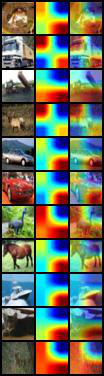

In [168]:
images = []
for i , (img, targets) in enumerate(trainloader):
    #print('오리지널:',img.shape)
    #img = img.squeeze()
    torch_img,normed_torch_img=normalize_image(img.cuda())
    #print(normed_torch_img)


    for gradcam, gradcam_pp in cam_dict.values():
        mask, _ = gradcam(normed_torch_img)
        #print(mask.shape,'df')
        heatmap, result = visualize_cam(mask, torch_img)
        #print('heatmap->{} result->{}',heatmap.shape,result.shape)

        images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))        
        img = img.squeeze()
        img = (img).permute(1, 2, 0)


    if i==10: break
images = make_grid(torch.cat(images, 0), nrow=3)
img_name = 'temp2.jpg'
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
print(output_path)
PIL.Image.open(output_path)

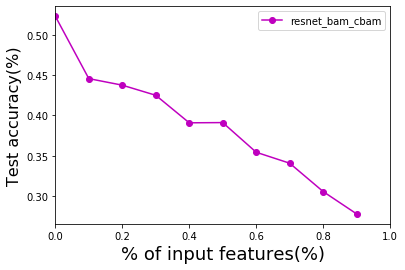

In [17]:
acc_bs=[]
steps_bs=[]

save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
save_name=save_dir+ 'ROAR_adjust_0_Resnet.pth'

for i in ratio:
    save_dir='/home/jake/Gits/AI college/XAI/2.problem/log/'
    save_name=save_dir+ 'ROAR_adjust_{}_Resnet_BAM_CBAM.pth.hdf5'.format(i)
    with h5py.File(save_name,'r') as hf:
        acc_b = np.array(hf['acc'])
        steps_b = np.array(hf['step'])
        acc_bs.append(acc_b)
        steps_bs.append(steps_b)
        
acc_bs = np.array(acc_bs)
steps_bs = np.array(steps_bs)

f = lambda x: x/100
acc_bs=f(acc_bs)

f = lambda x: x/10
steps_bs = f(steps_bs)


plt.plot(ratio,acc_bs,'-ok',marker='o',label="resnet_bam_cbam",color='m')
plt.xlabel('% of input features(%)',fontsize=18)
plt.ylabel('Test accuracy(%)',fontsize=16)
plt.legend(numpoints=1)
plt.xlim(0, 1);

# RESULT

In [ ]:
#PIL.Image.open(output_path)